# 时间序列聚类

根据某种相似度度量对数据集进行划分。

将相似的数据样本划分成若干个不同的子集(即簇)，将不相似的样本划分开来。

## 距离度量

### 闵可夫斯基距离

- 曼哈顿距离
- 欧式距离
- 切比雪夫距离

### DTW

DTW 将自动 warping 扭曲时间序列，即在时间轴上进行局部的缩放，使得两个序列的形态尽可能的一致，得到最大可能的相似度。 对于序列X和序列Y，X的长度为m，Y的长度为n。 定义一个mxn的网格，网格的每个元素为X和Y对应的点的距离，DTW算法就是从网络的左上角到右下角求一条最短路径值。

###  基于形状的距离

参考论文：k-Shape--- Efficient and Accurate Clustering of Time Series

解决空间和时间上的偏差
采用cross-correlation:常用于信号或图形中为时间滞后计算相似性。
固定y序列不动，在y序列上滑动x序列，并求他们之间每一次滑动的內积

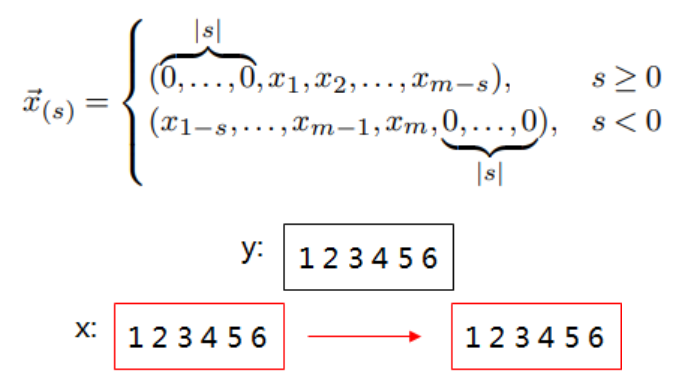

### 基于参数的距离

- 基于相关性的相似性度量方法
- 基于自相关的相似性度量方法
- 基于ARMA模型抽象时序的参数

## 聚类方法

### 基于距离/相似度的聚类方法

#### k-means聚类
主要思想：将每个样本分配到距离其最近的簇中心所在的簇。
- 优点：算法简单；高效。
- 缺点：只适用于簇状数据（易找到中心点）；且聚类中心容易受噪声影响；需要提前设置K值大小。

改进：2020年顶会fast-kmeans
- 近邻簇 （簇中心距离的一半）
- 稳定区域和活跃区域 (簇中心距离的一半的最小值，活跃区域进一步划分为几个环状带)

#### 层次聚类

主要思想：通过计算不同类别之间的相似度来创建一颗有层次的嵌套的树。

具体的：

1、将每个样本看成一个聚类簇。

2、计算各聚类簇之间的相似度

3、将最相近的两个合并，归为一类，形成一个新的聚类簇。

4、重复步骤2-3，直到满足终止条件。

终止条件：达到K个簇；两个簇之间的距离超过一定阈值，就不能合并了。

### 基于密度的方法

#### DBSCAN基本思想

主要思想：发现高密度的点，然后与其领域内的点及其附近的高密度点连成一片，形成各种簇。

具体的：

两个参数：邻域大小和密度阈值

- 任选一个点p，以领域大小为半径化圈，落在圈内的点的数量即p的密度，如果密度大于密度阈值，则该点为高密度点。

- 如果一个高密度点落在另一个高密度点里，则将两个高密度点连接起来。

- 如果一个低密度点也落在一个高密度点里，则将该低密度点和该高密度点连接起来。并且该低密度点被称为边界点。

- 如果低密度点不落在任意一个高密度点内，该点为异常点。

#### DBSCAN代码

In [ ]:
# DBSCAN code

"""
date:20190718
author:Jade
theme:基于密度的聚类算法
"""
#输出标记数组，每个对象属于每个簇或者为噪声点

import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn import datasets

class visitlist(object):
    def __init__(self,count=0):
        self.unvisitedlist = [i for i in range(count)]#记录未访问过的点
        self.visitedlist = list()#记录已经访问过的点
        self.unvisitednum = count #记录未访问过的点数量

    def visit(self,pointId):
        self.visitedlist.append(pointId)
        self.unvisitedlist.remove(pointId)
        self.unvisitednum -= 1

def dist(a,b):
    """
    计算两个元组之间的欧几里得距离
    """
    return np.sqrt(np.power(a-b,2).sum())

def dbscan(dataSet,eps,minPts):
    """
    :param dataSet:
    :param eps: 0.1
    :param minPts: 10
    :return:
    """
    nPoints = dataSet.shape[0]
    vPoints = visitlist(count=nPoints)
    k = -1
    #初始所有数据标记为-1
    C = [-1 for i in range(nPoints)]
    while vPoints.unvisitednum>0:
        P = random.choice(vPoints.unvisitedlist)
        vPoints.visit(P)
        # N：求P的邻域
        N = [i for i in range(nPoints) if dist(dataSet[i],dataSet[P])<=eps]
        if len(N) >= minPts: #P的邻域里至少有minPts个对象
            # 创建新簇，把P添加到新簇
            k += 1
            C[P] = k
            for pl in N:
                if pl in vPoints.unvisitedlist:
                    vPoints.visit(pl)
                    M = [i for i in range(nPoints) if dist(dataSet[i],dataSet[pl]) <= eps]
                    if len(M) >= minPts:
                        for i in M:
                            if i not in N:
                                N.append(i) # N长度增加，循环次数也增多了
                    if C[pl] == -1:
                        C[pl] = k
        else:
            C[P] = -1
    return C

if __name__ == '__main__':
    X1, Y1 = datasets.make_circles(n_samples=2000, factor=0.6, noise=0.05,random_state=1)
    X2, Y2 = datasets.make_blobs(n_samples=500, n_features=2, centers=[[1.5,1.5]],cluster_std=[[0.1]], random_state=5)

    X = np.concatenate((X1,X2))
    y_pred = dbscan(X,0.1,10)
    plt.figure(figsize=(12,9),dpi=80)
    plt.scatter(X[:,0], X[:,1],c=y_pred,marker='.')
    plt.show()

### 基于图的聚类

### [谱聚类](https://www.cnblogs.com/pinard/p/6221564.html)

- 将每个样本看成一个点，点之间的连接状况用权重矩阵表示。权重矩阵是个N*N维的矩阵，相连为1，不相连为0。

> 事实上，我们会求相似度矩阵来代替权重矩阵。

> 相似矩阵的三种求法：ϵ阈值、KNN和全连接。

- 用图分割的方法去划分整个图，将整个图分割成K个小图，使其图与图之间的连接权重之和最小，目标函数如下：

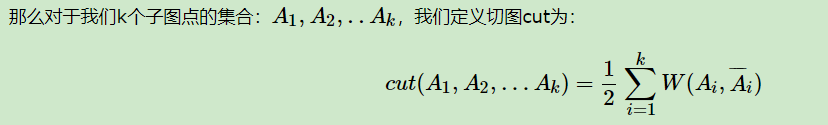

- 常用的分割方法有两种：Ratiocut(每个图的样本数量尽可能多)和Ncut(每个图图内样本间的权重尽可能大)，两种方法的目标函数都是基于上述目标函数上的改进。

通过公式变换，最终可转变为优化下列目标函数：

对于Ratiocut：

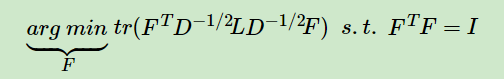

对于Ncut：

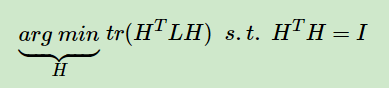

- 通过证明，优化的方式就是求L（拉普拉斯矩阵）或者标准化后的L的最小特征值对应的特征向量H。

- 最终对H做一次k-means得到最终聚类结果。

优点：能对高维数据进行降维

缺点：比较依赖相似距离度量

改进：计算nxn维的距离矩阵是很耗时间的，有一种方法是选取p个代表样本，只计算每个样本和这p个代表间的相似度，经过转换得到新的图的距离矩阵。

参见论文：Ultra-Scalable Spectral Clustering and Ensemble Clustering IEEE TRANSACTIONS ON KNOWLEDGE AND DATA ENGINEERING, VOL. 32, NO. 6, JUNE 2020

## 特殊技巧

### 子空间聚类

- 当遇到高维的数据时，传统的聚类方法往往耗费大量的时间，且聚类效果也会受到影响。为解决这一问题，基于子空间的聚类方法被广泛提出。
- 基于子空间的聚类方法认为不同簇内的样本往往只与部分维度特征相关。

子空间聚类被分为：

- 硬子空间聚类：去除无关和冗余的特征，对降维后的数据进行聚类。
- 软子空间聚类：
    - 所有簇共享一个特征子空间：给每个特征分配一个权值，所有特征的权值相加为一。
    - 不同簇存在不同的特征子空间：给每个特征分配一个权值向量，即每个特征对不同簇的形成的重要性。

降维方法：

- 特征值和特征向量
- [svd](https://zhuanlan.zhihu.com/p/29846048):左奇异矩阵可以用于对行数的压缩；右奇异矩阵可以用于对列(即特征维度)的压缩 (X = UTX)
- [pca](https://blog.csdn.net/program_developer/article/details/80632779):保留前面k个含有绝大部分方差的坐标轴。通过计算数据矩阵的协方差矩阵，然后得到协方差矩阵的特征值特征向量，选择特征值最大(即方差最大)的k个特征所对应的特征向量组成的矩阵。这样就可以将数据矩阵转换到新的空间当中，实现数据特征的降维。

还有一种子空间聚类的定义即：每个样本都能由其他样本线性表示，于是可转化为一个目标函数的优化问题。

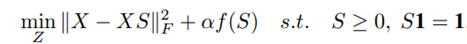

改进：

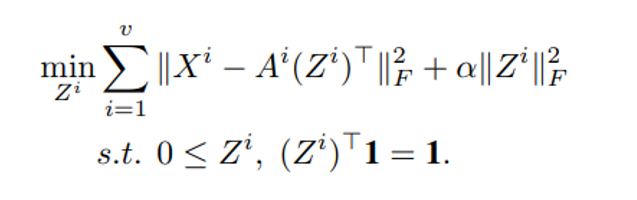

> 多变量时间序列是由多个随机变量在一段连续时间下观测得到的一组数据，有着高维度和多变量的特点。
> 目前已有的针对多元时间序列的聚类方法，大多用基于PCA的方法对时间维进行降维，很少考虑变量间的关系。

### 集成聚类

集成聚类主要包含两步：首先生成多个不同的聚类结果，然后整合多个聚类结果得到最终的聚类结果。

- 生成多个不同的聚类结果
    - 在不同参数设置下重复一个聚类算法
    - 采用不同的聚类方法
    - 在不同子空间或者子采样数据下运行聚类算法

- 整合多个聚类结果
     - pairwise-similarity的方法 
     - graph-based的方法 
     - median partition-based的方法

### 半监督聚类

- 成对限制
- 约束传播方法（图正则，或者子空间）

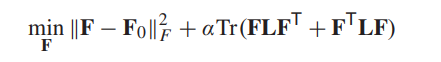

> (Fi - Fj)2*Sij